In [1]:
import numpy as np
import pickle 
import matplotlib.pyplot as plt
%matplotlib inline

def load_corpus(path):
    ret = []
    with open(path, "rb") as f:
        for line in f:
            for c in line.decode(): #python3 style
                if c.isalpha():
                    ret.append(c.lower())
                if c.isspace() and ret and not ret[-1].isspace():
                    ret.append(" ")
    ret = "".join(ret)
    return ret.strip()

def load_probabilities(path):
    ret = None
    with open(path, "rb") as f:
        ret = pickle.load(f)
    return ret

In [2]:
sequence = load_corpus("./Brown_sample.txt")
p = load_probabilities("./prob_vector.pickle")

In [6]:
class HMM(object):
    
    def __init__(self, p):
        self.pi = p[0]
        self.a = p[1]
        self.b = p[2]
        
    @staticmethod
    def log_sum_exp(seq):
        if abs(min(seq)) > abs(max(seq)):
            a = min(seq)
        else:
            a = max(seq)
        
        total = 0
        for x in seq:
            total += np.exp(x - a)
        return a + np.log(total)
    
    
    def forward(self, sequence):
        N = len(self.pi)
        alpha = []
        
        d1 = {}
        for i in range(1, N+1):
            d1[i] = self.pi[i] + self.b[i][sequence[0]]
        alpha.append(d1)
        
        for t in range(1,len(sequence)):
            d = {}
            o = sequence[t]
            
            for j in range(1, N+1):
                sum_seq = []
                for i in range(1,N+1):
                    sum_seq.append(alpha[-1][i] + self.a[i][j] + self.b[j][o])
                
                d[j] = self.log_sum_exp(sum_seq)
            alpha.append(d)
                    
        return alpha
    
    def forward_probability(self, alpha):
        return self.log_sum_exp(list(alpha[-1].values())) #python3 style
    
    def backward(self, sequence):
        N = len(self.pi)
        T = len(sequence)
        
        beta = []
        dT = {}
        for i in range(1,N+1):
            dT[i] = 0 #log1 = 0
        beta.append(dT)
        
        for t in range(T-2,-1,-1):
            d = {}
            o = sequence[t+1]
            for i in range(1,N+1):
                sum_seq = []
                for j in range(1,N+1):
                    sum_seq.append(self.a[i][j] + self.b[j][o] + beta[-1][j])
                    
                d[i] = self.log_sum_exp(sum_seq)
            
            beta.append(d)
        
        beta.reverse()
            
        return beta   
    
    def backward_probability(self, beta, sequence):
        N = len(self.pi)
        sum_seq = []
        
        for i in range(1,N+1):
            sum_seq.append(self.pi[i] + self.b[i][sequence[0]] + beta[0][i])
        return self.log_sum_exp(sum_seq)
    
    def xi(self, t, alpha, beta, sequence):
        N = len(self.pi)
        T = len(sequence)
        
        o = sequence[t+1]
        xi = {}
        sum_seq = []
        denom = self.log_sum_exp(list(alpha[-1].values()))
        for i in range(1,N+1):
            xi[i] = {}
            for j in range(1,N+1):
                numerator = alpha[t][i] + self.a[i][j] + self.b[j][o] + beta[t+1][j]
                xi[i][j] = numerator - denom
                
        return xi
    
    def gamma(self, t, alpha, beta, sequence):
        N = len(self.pi)
        T = len(sequence)
        
        o = sequence[t]
        denom = self.log_sum_exp(list(alpha[-1].values()))
        
        gamma = {}
        for i in range(1,N+1):
            numerator = alpha[t][i] + beta[t][i]
            gamma[i] = numerator - denom
        
        return gamma
    
    def forward_backward(self, sequence):
        N = len(self.pi)
        alpha = self.forward(sequence)
        beta = self.backward(sequence)
        T = len(sequence)
        
        xis = []
        for t in range(T-1):
            xis.append(self.xi(t, alpha, beta, sequence))
        gammas = []
        for t in range(T):
            gammas.append(self.gamma(t, alpha, beta, sequence))
        
        pi_hat = gammas[0]
        a_hat = {}
        b_hat = {}
        
        for i in range(1,N+1):
            a_hat[i] = {}
            b_hat[i] = {}
            
            sum_seq = []
            for t in range(T-1):
                sum_seq.append(gammas[t][i])
            a_hat_denom = self.log_sum_exp(sum_seq)
            
            for j in range(1,N+1):
                sum_seq = []
                for t in range(T-1):
                    sum_seq.append(xis[t][i][j])
                a_hat_num = self.log_sum_exp(sum_seq)
                a_hat[i][j] = a_hat_num - a_hat_denom
                
            sum_seq = []
            for t in range(T):
                sum_seq.append(gammas[t][i])
            b_hat_denom = self.log_sum_exp(sum_seq)
            for k in self.b[i]:
                sum_seq = []
                for t in range(T):
                    o = sequence[t]
                    if o == k:
                        sum_seq.append(gammas[t][i])
                b_hat_num = self.log_sum_exp(sum_seq)
                b_hat[i][k] = b_hat_num - b_hat_denom
        
        return (pi_hat, a_hat, b_hat)
    
    def update(self, sequence, cutoff_value):
        
        log_likelihoods = []
        initial_log = self.forward_probability(self.forward(sequence))
        log_likelihoods.append(initial_log)
        increase = cutoff_value + 1
        while (increase > cutoff_value):
            before = self.forward_probability(self.forward(sequence))
            new_p = self.forward_backward(sequence)
            self.pi = new_p[0]
            self.a = new_p[1]
            self.b = new_p[2]
            after = self.forward_probability(self.forward(sequence))
            print("previous observation prob: {:.4f}, new observation prob: {:.4f}".format(np.exp(before), np.exp(after)))
            print("previous observation log likelihood: {:.4f}, new observation log likelihood: {:.4f}".format(before, after))
            increase = after - before
            log_likelihoods.append(after)
        return log_likelihoods, new_p
    
    def Viterbi(self, sequence):
    
        N = len(self.pi) #Number of states available
        alpha = [] #For saving the maximum log probabilities
        d1 = {}

        for i in range(1,N+1):
            d1[i] = h.pi[i] + h.b[i][sequence[0]] #Initialization
        alpha.append(d1)

        for t in range(1,len(sequence)-1):
            d = {}
            d_temp = {}
            log_likelihoods = []
            for i in range(1,N+1): #start state
                d[i] = {}
                for j in range(1,N+1): #terminal state
                    d[i][j] = alpha[-1][i] + h.a[i][j] + h.b[j][sequence[t]]   

            #Save max log likelihood ending in each state, at time t
            for j in range(1,N+1):
                temp = []
                for i in range(1,N+1):
                    temp.append(d[i][j])
                d_temp[j] = max(temp)
            alpha.append(d_temp)
            
        optimal_states = []
        state = list(alpha[-1].values()).index(max(list(alpha[-1].values())))+1 #last optimal state
        optimal_states.append(state)
        for back_t in range(t, 0, -1): #start back tracing
            #print("time {}".format(back_t))
            temp_list = []
            for prev_state in range(1,N+1):
                temp_list.append(alpha[back_t-1][prev_state] + h.a[prev_state][state] + h.b[state][sequence[back_t]])
            state = temp_list.index(max(temp_list))+1
            optimal_states.append(state)

        optimal_states.reverse() #reverse the optimal hidden states so that states starts in time.
        return optimal_states, alpha
        #print("Viterbi decoding done... Optimal hidden states are: {}".format(optimal_states))
    

In [7]:
h = HMM(p)

In [11]:
# print('initial state probabilities before training')
# for i in range(1,4+1):
#     print(np.exp(h.pi[i]))
# print('state transition probabilities before training')
# for i in range(1,4+1):
#     for j in range(1,4+1):
#         print(np.exp(h.a[i][j]))
#     print('\n')

initial state probabilities before training
0.2790602543027226
0.35816453465344517
0.15222317381150546
0.21055203723232674
state transition probabilities before training
0.3908493040227309
0.18938197908059773
0.0770514911339938
0.3427172257626776


0.43354011383893265
0.2089676606207099
0.19686737445155456
0.16062485108880287


0.25
0.20558981380760497
0.22755393102410978
0.31685625516828525


0.40571326405494107
0.0654317928462989
0.2502573746425905
0.2785975684561695




In [17]:
log_likelihoods, new_p = h.update(sequence,1) #Actually performs HMM training in an EM style

previous observation prob: 0.0000, new observation prob: 0.0000
previous observation log likelihood: -9201.3496, new observation log likelihood: -8070.9616
previous observation prob: 0.0000, new observation prob: 0.0000
previous observation log likelihood: -8070.9616, new observation log likelihood: -8066.6165
previous observation prob: 0.0000, new observation prob: 0.0000
previous observation log likelihood: -8066.6165, new observation log likelihood: -8060.8745
previous observation prob: 0.0000, new observation prob: 0.0000
previous observation log likelihood: -8060.8745, new observation log likelihood: -8052.5557
previous observation prob: 0.0000, new observation prob: 0.0000
previous observation log likelihood: -8052.5557, new observation log likelihood: -8039.7711
previous observation prob: 0.0000, new observation prob: 0.0000
previous observation log likelihood: -8039.7711, new observation log likelihood: -8019.7449
previous observation prob: 0.0000, new observation prob: 0.0000


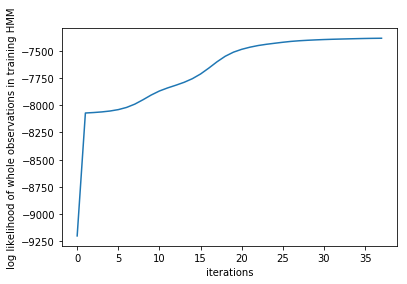

In [19]:
plt.plot(np.arange(len(log_likelihoods)), log_likelihoods)
plt.xlabel('iterations')
plt.ylabel('log likelihood of whole observations in training HMM')

In [20]:
print('initial state probabilities after HMM training')
for i in range(1,4+1):
    print(np.exp(h.pi[i]))
print('state transition probabilities after HMM training')
for i in range(1,4+1):
    for j in range(1,4+1):
        print(np.exp(h.a[i][j]))
    print('\n')

initial state probabilities after HMM training
1.0000000000427463
9.313898882433713e-87
6.281161757004623e-79
4.396126497654772e-128
state transition probabilities after HMM training
0.006853584490905768
0.4599297458356615
1.9291427866137335e-09
0.5332166677443866


0.012523654416700699
0.18408775307043942
2.559341750987588e-05
0.8033629990952229


0.5142080806384013
0.0178546983404443
0.0006834463540007576
0.46725377466715423


0.4673382430577756
2.132657039354341e-06
0.42045399921952564
0.11220562506559045




In [31]:
optimal_states, alpha = h.Viterbi(sequence[:40])
print(sequence[:40], optimal_states, alpha[-1])

the fulton county grand jury said friday [1, 2, 2, 4, 1, 4, 3, 1, 4, 3, 4, 1, 2, 4, 3, 1, 2, 4, 1, 2, 4, 3, 1, 4, 3, 4, 1, 2, 4, 3, 4, 4, 1, 4, 3, 1, 4, 1, 4] {1: -122.60723816850613, 2: -110.25846421561731, 3: -123.06545892472516, 4: -107.19784688875708}
